In [3]:
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import joblib

In [52]:
def load_and_prepare_data(seed_dir, seeds_train,
                         is_filename=False, as_frac=False):
    train_df = []
    for i in seeds_train:
        if is_filename:
            seed_df = pd.read_csv(seed_dir+i.split('\\')[-1])
        else:
            seed_df = pd.read_csv(seed_dir+f'seir_seed_{i}.csv')
            
        seed_df['day'] = np.arange(len(seed_df))
        seed_df = seed_df[(seed_df['E'] > 0)|(seed_df['I'] > 0)].copy()
        #seed_df = seed_df[seed_df['Beta'] > 0].copy()
        
        train_df.append(seed_df)
        
    
    train_df = pd.concat(train_df, ignore_index=True)
    train_df = train_df[train_df['Beta'] > 0].copy()
    
    if as_frac:
        pop = train_df.iloc[0,:4].sum()
        train_df.iloc[:,:4] = train_df.iloc[:,:4]/pop
    #train_df.loc[:,'Beta'] = train_df.loc[:,'Beta'].replace(0, 1e-7)
    #train_df.loc[:,'Beta'] = train_df.loc[:,'Beta'].fillna(1e-7)
    train_df['log_Beta'] = np.log(train_df['Beta'])
    return train_df


def train_model(train_df, model_file, features, 
                degree=3, alpha=0.0001, max_iter=5000):
    X = train_df[features].values
    y = train_df['log_Beta'].values

    model = make_pipeline(
        StandardScaler(),
        PolynomialFeatures(include_bias=False, degree=degree),
        SGDRegressor(alpha=alpha, max_iter=max_iter, 
                     penalty='l2', warm_start=False)
    )
    model.fit(X, y)
    print(model.score(X, y))
    # Сохраняем лучшую модель
    joblib.dump(model, model_file)

    
def plot(model_file, train_df, features):
    model = joblib.load(model_file)
    X = train_df[features].values
    y = train_df['log_Beta'].values
    pred = model.predict(X)

    print('MSE: ', mean_squared_error(y, pred))
    fig = plt.figure(figsize=(12, 3)) 
    # how many train points to show
    size = 1500
    plt.plot(y[:size], ls='-', marker='', label='real Beta')
    plt.plot(pred[:size], ls='-', marker='', label='predicted Beta')
    plt.grid()
    plt.legend()


In [5]:
# мб нормальную модель авторегрессии?
#df_seeds = pd.read_csv('initial_data/seeds_set_parameters.csv')
#seeds_train = df_seeds[df_seeds.set!='test']['seed_number'].values
features = ['day',  
            'S', 
            'E', 
            'I', 
            #'R'
           ]

## barabasi-albert

0.7264856636686996
MSE:  0.1303725308540403


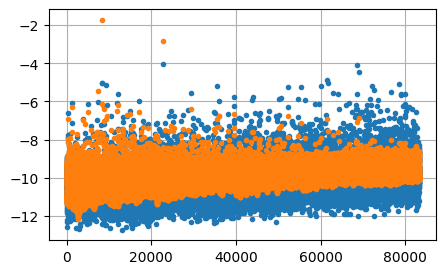

In [4]:
seed_dir='initial_data/initial_data_ba_10000/'
model_file = seed_dir+'regression_day_SEIR_prev_I_for_seir.joblib'


train_df = load_and_prepare_data(seed_dir, seeds_train)
train_model(train_df, model_file, features)
plot(model_file, features)

In [39]:
seed_dir='initial_data/initial_data_ba_50000/'
model_file = seed_dir+'regression_day_SEIR_prev_I_for_seir.joblib'

train_df = load_and_prepare_data(seed_dir, seeds_train)
train_model(train_df, model_file, features)
plot(model_file, features)

FileNotFoundError: [Errno 2] No such file or directory: 'initial_data/initial_data_ba_50000/seir_seed_0.csv'

0.7742044013608336


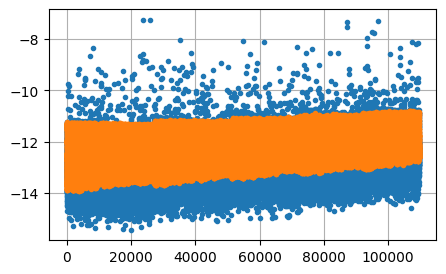

In [71]:
seed_dir='initial_data/initial_data_ba_100000/'
model_file = seed_dir+'regression_day_SEIR_prev_I_for_seir.joblib'

train_df = load_and_prepare_data(seed_dir, seeds_train)
train_model(train_df, model_file, features)
plot(model_file, features)

### new

In [ ]:

features = ['day',  
            'S', 
            'E', 
            'I', 
            #'R'
           ]

0.8193998152994729
MSE:  0.1404653739369534


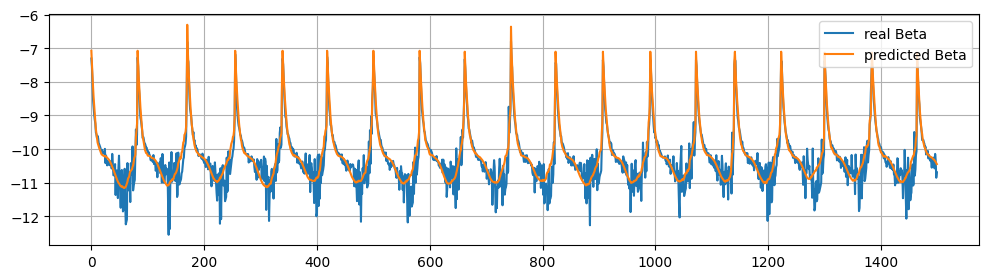

In [165]:
df_seeds_n = pd.read_csv('initial_data/new_seeds_parameters.csv')
seeds_train_n = df_seeds_n[df_seeds_n.set=='train']['file'].values

seed_dir='initial_data/new_ba_10000/'
model_file = seed_dir+'regression_day_SEIR_prev_I_for_seir.joblib'

is_filename = True
as_frac=True


train_df = load_and_prepare_data(seed_dir, seeds_train_n,
                                is_filename=is_filename, as_frac=as_frac)

train_model(train_df.dropna(), model_file, features,
           degree=3, alpha=0.01, max_iter=10000)


seeds_val_n = df_seeds_n[df_seeds_n.set=='val']['file'].values
val_df = load_and_prepare_data(seed_dir, seeds_val_n,
                                is_filename=is_filename, as_frac=as_frac)


plot(model_file, val_df, features)

In [166]:
model = joblib.load(model_file)
X = train_df[features].values
y = train_df['log_Beta'].values

In [185]:
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV, RandomizedSearchCV
from scipy.stats import randint

np.random.seed(42)

param_distributions = {"sgdregressor__alpha": [0.1,0.01,0.001,0.0001],
                       "polynomialfeatures__degree": [2,3,4]
                      }
search = RandomizedSearchCV(model, param_distributions,
                               #resource='n_estimators',
                               #max_resources=10
                            n_iter=12,
                              ).fit(X, y)
search.best_params_  

{'sgdregressor__alpha': 0.01, 'polynomialfeatures__degree': 3}

In [194]:
search.best_score_

np.float64(0.7383463946755515)

In [189]:
search.cv_results_['params']

[{'sgdregressor__alpha': 0.1, 'polynomialfeatures__degree': 2},
 {'sgdregressor__alpha': 0.01, 'polynomialfeatures__degree': 2},
 {'sgdregressor__alpha': 0.001, 'polynomialfeatures__degree': 2},
 {'sgdregressor__alpha': 0.0001, 'polynomialfeatures__degree': 2},
 {'sgdregressor__alpha': 0.1, 'polynomialfeatures__degree': 3},
 {'sgdregressor__alpha': 0.01, 'polynomialfeatures__degree': 3},
 {'sgdregressor__alpha': 0.001, 'polynomialfeatures__degree': 3},
 {'sgdregressor__alpha': 0.0001, 'polynomialfeatures__degree': 3},
 {'sgdregressor__alpha': 0.1, 'polynomialfeatures__degree': 4},
 {'sgdregressor__alpha': 0.01, 'polynomialfeatures__degree': 4},
 {'sgdregressor__alpha': 0.001, 'polynomialfeatures__degree': 4},
 {'sgdregressor__alpha': 0.0001, 'polynomialfeatures__degree': 4}]

In [190]:
search.cv_results_['rank_test_score']

array([ 5,  3,  2,  4,  7,  1,  6,  8,  9, 10, 11, 12], dtype=int32)

0.8153109020548217
MSE:  0.14887479764813755


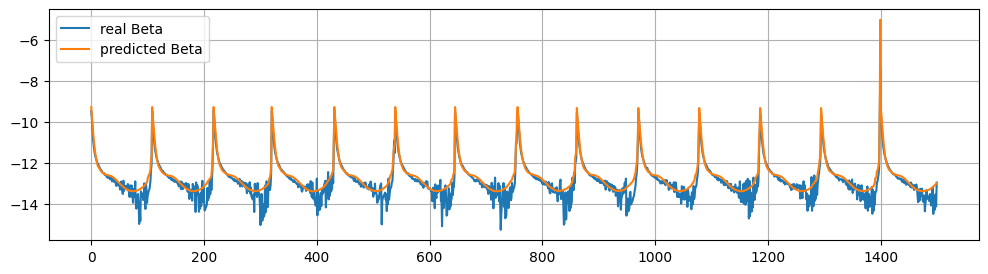

In [160]:
df_seeds_n = pd.read_csv('initial_data/new_seeds_parameters.csv')
seeds_train_n = df_seeds_n[df_seeds_n.set=='train']['file'].values

seed_dir='initial_data/new_ba_100000/'
model_file = seed_dir+'regression_day_SEIR_prev_I_for_seir.joblib'

is_filename = True
as_frac=True


train_df = load_and_prepare_data(seed_dir, seeds_train_n,
                                is_filename=is_filename, as_frac=as_frac)

train_model(train_df.dropna(), model_file, features,
           degree=3, alpha=0.01, max_iter=10000)


seeds_val_n = df_seeds_n[df_seeds_n.set=='val']['file'].values
val_df = load_and_prepare_data(seed_dir, seeds_val_n,
                                is_filename=is_filename, as_frac=as_frac)


plot(model_file, val_df, features)

0.7614920393797042
MSE:  0.13451467737787265


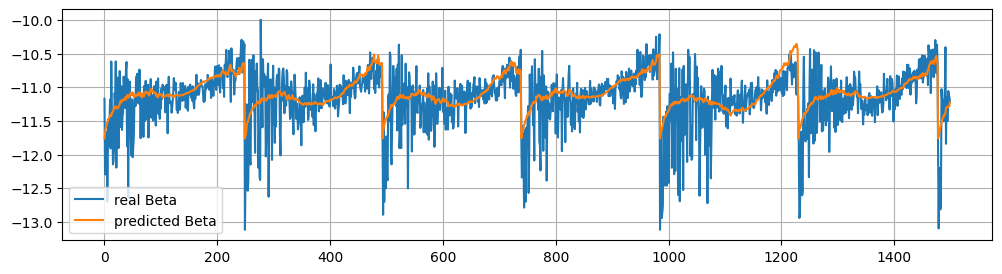

In [159]:
df_seeds_n = pd.read_csv('initial_data/new_seeds_parameters.csv')
seeds_train_n = df_seeds_n[df_seeds_n.set=='train']['file'].values

seed_dir='initial_data/new_sw_10000/'
model_file = seed_dir+'regression_day_SEIR_prev_I_for_seir.joblib'


is_filename = True
as_frac=True


train_df = load_and_prepare_data(seed_dir, seeds_train_n,
                                is_filename=is_filename, as_frac=as_frac)

train_model(train_df.dropna(), model_file, features,
           degree=3, alpha=0.01, max_iter=10000)


seeds_val_n = df_seeds_n[df_seeds_n.set=='val']['file'].values
val_df = load_and_prepare_data(seed_dir, seeds_val_n,
                                is_filename=is_filename, as_frac=as_frac)


plot(model_file, val_df, features)

0.5727546827931307
MSE:  0.1178969287369228


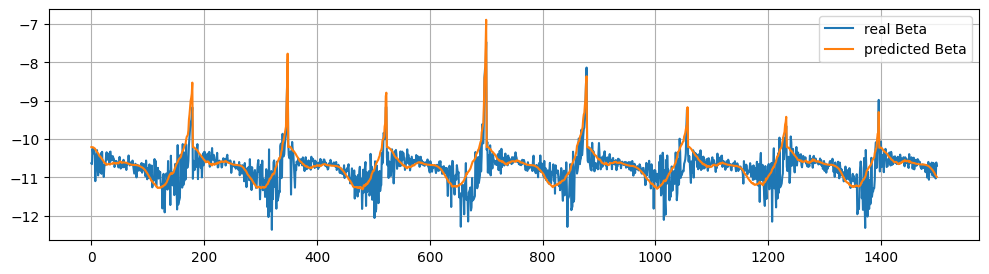

In [158]:
df_seeds_n = pd.read_csv('initial_data/new_seeds_parameters.csv')
seeds_train_n = df_seeds_n[df_seeds_n.set=='train']['file'].values

seed_dir='initial_data/new_r_10000/'
model_file = seed_dir+'regression_day_SEIR_prev_I_for_seir.joblib'


is_filename = True
as_frac=True


train_df = load_and_prepare_data(seed_dir, seeds_train_n,
                                is_filename=is_filename, as_frac=as_frac)

train_model(train_df.dropna(), model_file, features,
           degree=3, alpha=0.01, max_iter=10000)


seeds_val_n = df_seeds_n[df_seeds_n.set=='val']['file'].values
val_df = load_and_prepare_data(seed_dir, seeds_val_n,
                                is_filename=is_filename, as_frac=as_frac)


plot(model_file, val_df, features)

## small world

0.7831986579904753


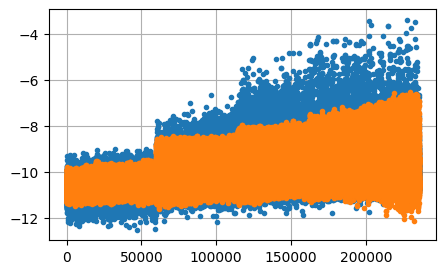

In [73]:
seed_dir='initial_data/initial_data_sw_10000/'
model_file = seed_dir+'regression_day_SEIR_prev_I_for_seir.joblib'

train_df = load_and_prepare_data(seed_dir, seeds_train)
train_model(train_df, model_file, features)
plot(model_file, features)

0.7995411630648883


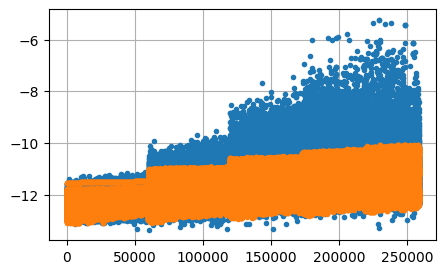

In [84]:
seed_dir='initial_data/initial_data_sw_50000/'
model_file = seed_dir+'regression_day_SEIR_prev_I_for_seir.joblib'

train_df = load_and_prepare_data(seed_dir, seeds_train)
train_model(train_df, model_file, features)
plot(model_file, features)

0.8006524916040959


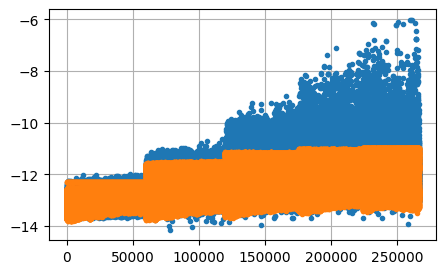

In [86]:
seed_dir='initial_data/initial_data_sw_100000/'
model_file = seed_dir+'regression_day_SEIR_prev_I_for_seir.joblib'

train_df = load_and_prepare_data(seed_dir, seeds_train)
train_model(train_df, model_file, features)
plot(model_file, features)

## random

0.5618567014420793
MSE:  0.11139942909935087


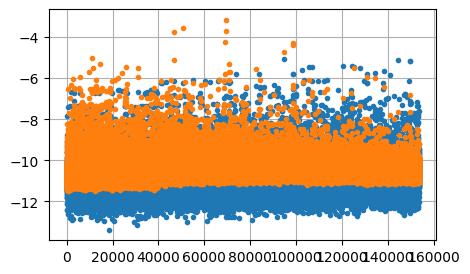

In [5]:
seed_dir='initial_data/initial_data_r_10000/'
model_file = seed_dir+'regression_day_SEIR_prev_I_for_seir.joblib'

train_df = load_and_prepare_data(seed_dir, seeds_train)
train_model(train_df, model_file, features)
plot(model_file, features)

0.5955909773013708
MSE:  0.11026524559092088


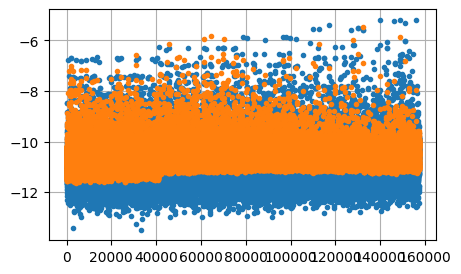

In [6]:
df_seeds_n = pd.read_csv('initial_data/new_seeds_parameters.csv')
seeds_train_n = df_seeds_n[df_seeds_n.set!='test']['file'].values

seed_dir='initial_data/new_r_10000/'
model_file = seed_dir+'regression_day_SEIR_prev_I_for_seir.joblib'

train_df = load_and_prepare_data(seed_dir, seeds_train_n,
                                is_filename=True)
train_model(train_df, model_file, features)
plot(model_file, features)

0.6352484969279337
MSE:  0.10081997521356312


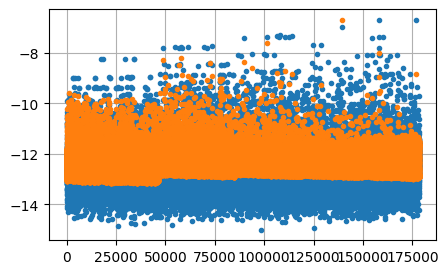

In [5]:
seed_dir='initial_data/initial_data_r_50000/'
model_file = seed_dir+'regression_day_SEIR_prev_I_for_seir.joblib'

train_df = load_and_prepare_data(seed_dir, seeds_train)
train_model(train_df, model_file, features)
plot(model_file, features)

0.6529889991426283
MSE:  0.09847972522478192


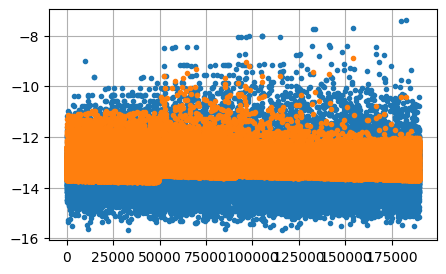

In [7]:
seed_dir='initial_data/initial_data_r_100000/'
model_file = seed_dir+'regression_day_SEIR_prev_I_for_seir.joblib'

train_df = load_and_prepare_data(seed_dir, seeds_train)
train_model(train_df, model_file, features)
plot(model_file, features)

0.6737600829699402
MSE:  0.10073813081773021


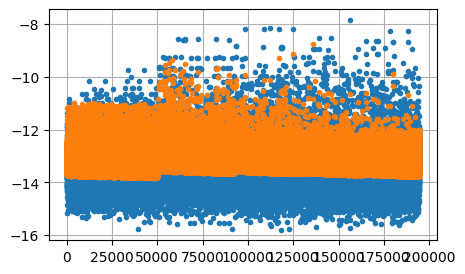

In [8]:
df_seeds_n = pd.read_csv('initial_data/new_seeds_parameters.csv')
seeds_train_n = df_seeds_n[df_seeds_n.set!='test']['file'].values

seed_dir='initial_data/new_r_100000/'
model_file = seed_dir+'regression_day_SEIR_prev_I_for_seir.joblib'

train_df = load_and_prepare_data(seed_dir, seeds_train_n,
                                is_filename=True)
train_model(train_df, model_file, features)
plot(model_file, features)